<a href="https://colab.research.google.com/github/lstival/mo443/blob/main/T4/T4_MO443.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import cv2

import tqdm
#Lib to define the argument when call the file
import argparse

In [2]:
# Paramets to read the origin image and text file
parser = argparse.ArgumentParser(description='Halftoning')
parser.add_argument('--a', default=33.3, help='Angle to rotate the image')
parser.add_argument('--e', default=None, help='Factor to scale the image')
parser.add_argument('--d', default=None, help='Define the new size of image in pixels')
parser.add_argument('--m', default=0, help='Define the interpolation method')
parser.add_argument('--i', default="baboon.png", help='Define the path ro read the image')
parser.add_argument('--o', default="output_image.png", help='Define the name of image with transfomation applied')

# Parse the paraments passed to the script
# opt = parser.parse_args()
opt = parser.parse_args(args=[])

In [3]:
# '1024,1000'

https://www.ic.unicamp.br/~helio/disciplinas/MO443/trabalho4.pdf

## Exercicios (1)
Realizar a perspectiva da imagem

In [4]:
image_path = "https://www.ic.unicamp.br/~helio/imagens_png/"
image_name_pesp = "baboon_perspectiva.png"
image_name = "baboon.png"

In [5]:
img_pespective = io.imread(f"{image_path}{image_name_pesp}")
img = io.imread(f"{image_path}{image_name}")

Text(0.5, 1.0, 'Transformed image')

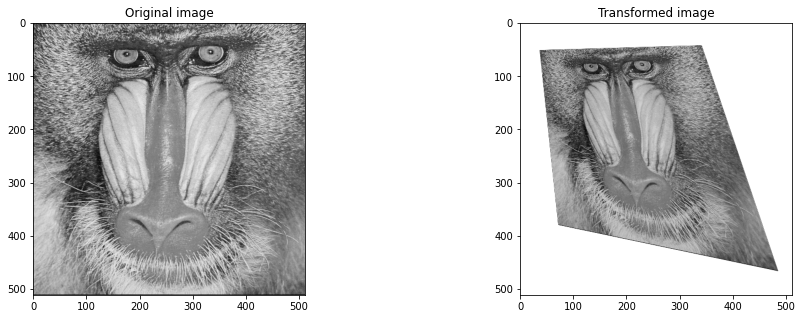

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16,5))

axs[0].imshow(np.array(img), cmap='gray')
axs[0].set_title("Original image")

axs[1].imshow(np.array(img_pespective), cmap='gray')
axs[1].set_title("Transformed image")

 ## Perspective Projection

In [7]:
#Coordenadas originais da imagem transacionada
pts1 = np.float32([[37, 51], [342, 42], [485, 467], [73, 380]]) 

#Coordenadas para a nova projeção
pts2 = np.float32([[0, 0], [511, 0], [511, 511], [0, 511]]) 

In [8]:
#Gerando a matriz contendo as perspectiva para transformação
matrix = cv2.getPerspectiveTransform(pts1, pts2)

#Matriz inversa para tirar a perspectiva
matrix_inverse = np.linalg.inv(matrix)
matrix_inverse

array([[ 4.43270110e-01,  3.99404002e-02,  3.47161547e+01],
       [-3.08639257e-02,  4.67913302e-01,  4.78519971e+01],
       [-3.41393905e-04, -3.58371600e-04,  9.38274452e-01]])

In [9]:
#New image without perspective
new_img = np.zeros(img_pespective.shape, dtype=img.dtype)

for lin in range(new_img.shape[0]):
    for col in range(new_img.shape[1]):

        new_col, new_line, w = np.matmul(matrix_inverse, [col, lin, 1])
        
        new_img[lin, col] = img_pespective[round(new_line/w), round(new_col/w)]

Text(0.5, 1.0, "Transfomed image x'")

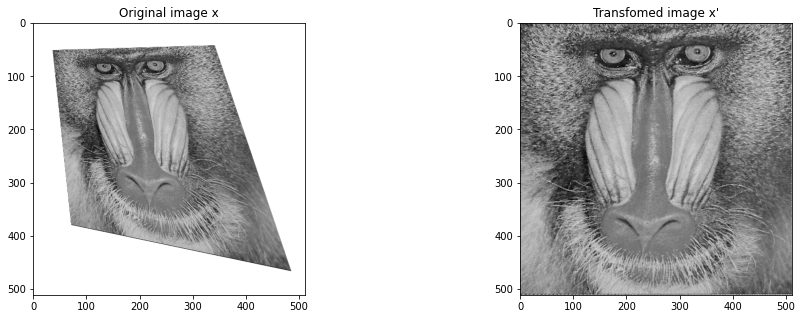

In [10]:
#Gerando a matriz contendo as perspectiva para transformação
matrix = cv2.getPerspectiveTransform(pts1, pts2)

fig, axs = plt.subplots(1, 2, figsize=(16,5))

axs[0].imshow(np.array(img_pespective), cmap='gray')
axs[0].set_title("Original image x")

axs[1].imshow(new_img, cmap='gray')
axs[1].set_title("Transfomed image x'")

## Exercicio (2)
Criar um programa que realize a escala ou rotação, aplicando a interpolação solicitada.

In [11]:
def get_persp_points(p0, matrix):

    #Incluing the Z value to matmul.
    p0.extend([1])
    p1 = p0

    #Generate the x' value
    x = (p1[0] * matrix[0][0]) + (p1[1] * matrix[0][1]) + (p1[2] * matrix[0][2])

    #Generate the y' value
    y = (p1[0] * matrix[1][0]) + (p1[1] * matrix[1][1]) + (p1[2] * matrix[1][2])

    #Normalizin fator (W values)
    norm = (p1[0] * matrix[2][0]) + (p1[1] * matrix[2][1]) + (p1[2] * matrix[2][2])

    #Return a list with the values
    return [x/norm, y/norm]

## Funções de apoio

In [12]:
def geometric_function(height, width, transform_function, 
                       interpolation_function, scales, img):
    """
    Function recive the values of metrics and transforms the image
    using the scale informed in 'scale_factor'.
    
    Interpolat the values using the function in 'interpolation_function'
    and return the new image.
    """

    img_pad = np.pad(img,10,mode='reflect')
    
    new_img = np.zeros((height, width), dtype=img.dtype)

    for line in tqdm.tqdm(range(height)):
        for col in range(width):

            line_projected, col_projected = transform_function(line, col, scales)

            pixel_value = interpolation_function(line_projected, col_projected, img_pad)
            new_img[line, col] = pixel_value

    return new_img

In [13]:
def geometric_function_rotation(height, width, transform_function, 
                       interpolation_function, transform_parameter, img):
    
    """
    Function recive the values of metrics and transforms the image
    using the rotate using the matriz informed in 'transform_parameter'.
    
    Interpolat the values using the function in 'interpolation_function'
    and return the new image.
    """
    img_pad = np.pad(img,10,mode='reflect')
    
    new_img = np.zeros((height, width), dtype=img.dtype)

    for line in  tqdm.tqdm(range(height)):
        for col in range(width):

            line_projected, col_projected = apply_rotation(line, col, transform_parameter)

            if in_image(line_projected, col_projected, height, width):

                pixel_value = interpolation_function(line_projected, col_projected, img_pad)

            else:
                pixel_value = 0
            new_img[line, col] = pixel_value

    return new_img

In [14]:
def scale_img(line, col, scales):
    """
    Recive the x (line) and y (col) of a image
    and a scale_factor, and calculate the new point in the
    scaled image.
    """
    scale_factor_x = scales[0]
    scale_factor_y = scales[1]

    line_projected = np.round(line/scale_factor_x)
    col_projected = np.round(col/scale_factor_y)

    return line_projected, col_projected

In [15]:
def plot_transform(img, new_img):
    """
    Recives a orignal image an transformed image,
    plot both in the screen.
    """
    fig, axs = plt.subplots(1, 2, figsize=(16,5))

    axs[0].imshow(img, cmap='gray')
    axs[0].set_title("Imagem Original")

    axs[1].imshow(new_img, cmap='gray')
    axs[1].set_title("Com transformação aplicada")

In [16]:
def rotate_image(image, angle):
    """
    Recives the image and the angle in degrees counterclockwise
    and return the matriz to realize this operation.
    """
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    
    return rot_mat

In [17]:
def apply_rotation(x, y, rotation_matriz):
    """
    Using the matriz generate in the function 'rotate_image'
    get the new x and y, of the original points.
    """
    new_x = rotation_matriz[0][0] * x + rotation_matriz[0][1] * y + rotation_matriz[0][2]
    new_y = rotation_matriz[1][0] * x + rotation_matriz[1][1] * y + rotation_matriz[1][2]

    return  new_x, new_y

In [18]:
def in_image(x,y, heigth, width, diff_factor=1):
    """
    Test if the values (x and y) are in the image,
    otherwise return False.
    """
    if x < 0 or x > heigth-diff_factor:
        return False
    if y < 0 or y > width-diff_factor:
        return False

    return True

## Interpolações

Abaixo serão implementadas as técnicas de interpolação solicitadas na descrição do problema e verificado o MSE entre os valores do pixels originais (imagem fornecida sem rotação '*baboon.pnh*') com a versão interpolada.

### Vizinho mais próximo

In [19]:
def nesrest_neib(line, col, img):
    """
    Identify the nearest neighorn in the original image,
    using the x and y on the new image.
    """

    pixel_value = img[int(round(line)), int(round(col))]

    return pixel_value

### Bilinear

In [20]:
def bilinear_interpolation(x, y, img):
    """
    Apply the bilinear interpolation in the 'img'
    and return the value to the pixel in new image.
    """
    dx = abs(round(x) - x)
    dy = abs(round(y) - y)

    x = int(x)
    y = int(y)

    try:
        x1 = (1 - dx) * (1-dy) * img[x,y]
        x2 = (dx*(1-dy) * img[x+1, y])
        x3 = ((1-dx) * dy) * img[x, y+1]
        x4 = (dx * dy) * img[x+1, y+1]

        pixel_value = x1+x2+x3+x4
    except:
        pixel_value = img[x, y]

    return pixel_value

### Bicúbica

In [21]:
def P_function(t):
    """
    Recebe o valor t e o retorna caso for maior que 0,
    caso contrário retorna 0.

    """
    if t > 0:
        t = t
    else:
        t = 0
    return t

def R_function(s):
    """
    Fucntion utilized to create the bicubic interpolation,
    recive a value 's' and return the new value to a pixel.
    """
    t1 = P_function(s + 2) ** 3
    t2 = 4 * P_function(s + 1) ** 3
    t3 = 6 * P_function(s) ** 3
    t4 = 4 * P_function(s - 1) ** 3

    pixel_value = 0.16 * (t1 - t2 + t3 - t4)

    return pixel_value

In [22]:
def bicubic_interpolation(x, y, img):
    """
    Apply the bicuib interpolation in the 'img'
    and return the value to the pixel in new image.
    """
    ms = [-1,0,1,2]
    ns = [-1,0,1,2]

    dx = abs(round(x) - x)
    dy = abs(round(y) - y)

    x = int(x)
    y = int(y)

    pixel_value = 0

    for m in ms:
        for n in ns:
            try:
                pixel_value += img[x+m, y+n] * R_function(m-dx) * R_function(dy-n)
            except:
                pixel_value += img[x, y] * R_function(m-dx) * R_function(dy-n)
    return pixel_value

### Polinômios de Lagrange

In [23]:
def L_function(n, dx, dy, x, y, img):
    
    img1=img[x-1, y + n -2]
    img2=img[x, y + n - 2]
    img3=img[x+1, y + n - 2]
    img4=img[x+2,y + n - 2]
    
    t1 = ((-dx *(dx -1)) * (dx -2) * img1) /6
    t2 = ((dx + 1) * (dx - 1) * (dx - 2) * img2) /2
    t3 = ((-dx*(dx+1)) * (dx-2) * img3) /2
    t4 = (dx*(dx+1)*(dx-1) * img4) /6

    L_value = t1 + t2 + t3 + t4

    return L_value

In [24]:
def lagrange_interpolation(x, y, img):
    dx = abs(round(x) - x)
    dy = abs(round(y) - y)

    x = int(x)
    y = int(y)

    t1 = (-dy*(dy-1)*(dy-2)* L_function(1, dx, dy, x, y, img)) /6
    t2 = ((dy+1)*(dy-1)*(dy-2)* L_function(2, dx, dy, x, y, img)) /2
    t3 = (-dy*(dy+1)*(dy-2)* L_function(3, dx, dy, x, y, img)) /2
    t4 = (dy*(dy+1)*(dy-1)* L_function(4, dx, dy, x, y, img)) /6

    pixel_value = t1 + t2 + t3 + t4

    return pixel_value

## Parâmetros para as transformações

In [25]:
opt.e = 15
# opt.m = 0

#Read image
img = io.imread(f"{opt.i}")

In [26]:
def get_scale_factor(img_shape, new_height, new_width):
    list_scales = []
    list_scales.append(new_height/img_shape[0])
    list_scales.append(new_height/img_shape[1])
    return list_scales

In [27]:
#List of avaliables methods
function_list = [geometric_function, geometric_function_rotation]

#List of possibles interpolations
interpolation_list = [nesrest_neib, bilinear_interpolation, 
                      bicubic_interpolation, lagrange_interpolation]

#The dimesion of the original img
if len(img.shape) > 2:
    height, width, channel = img.shape
else:
    height, width = img.shape

#Validate to apply scale
if opt.e:
    #Select the scale functio
    function = function_list[0]
    
    #New size of image (after scale)
    new_height = int(height * opt.e)
    new_width = int(width * opt.e)
    
    #Define the scale factor
    transformation = get_scale_factor(img.shape, new_height, new_width)
    
    method_to_transform = scale_img
    
    opt.a = None
    
    print(f"Applying scale in image to {new_height}, {new_width}")

#Validation to apply the scale directly   
if opt.d:
    #Select the scale functio
    function = function_list[0]
      
    #Define the scale factor
    transformation = get_scale_factor(img.shape, 
                                      np.array(opt.d.split(',')).astype(int)[0],
                                      np.array(opt.d.split(',')).astype(int)[1])
    
    method_to_transform = scale_img
    
    new_height, new_width = np.array(opt.d.split(',')).astype(int)
    
    opt.a = None
    print(f"Applying scale in image to {new_height}, {new_width}")
    
#Test to apply the rotation
if opt.a:
    #Select the scale functio
    function = function_list[1]
    
    #Define the angle to rotate the image
    angle = opt.a
    
    #Create the rotation matriz
    transformation = rotate_image(img, angle)
    
    #Define the center of image
    image_center = tuple(np.array(img.shape[1::-1]) / 2)
    
    method_to_transform = apply_rotation
    
    #Avoid to execute combination of rotation and scala
    opt.e = None
    opt.d = None
    
    #Define the size of image
    new_height,new_width = height, width
    
    #Create the rotation matriz
    print(f"Applying rotation in image with {angle} degrees")

#Get the interpolation method from avaliables
interpolation_method = interpolation_list[opt.m]
print(f"Using the to '{interpolation_method.__name__}' interpolate")

Applying scale in image to 7680, 7680
Using the to 'nesrest_neib' interpolate


### Aplicando transformações

100%|██████████████████████████████████████████████████████████████████████████████| 7680/7680 [19:59<00:00,  6.40it/s]


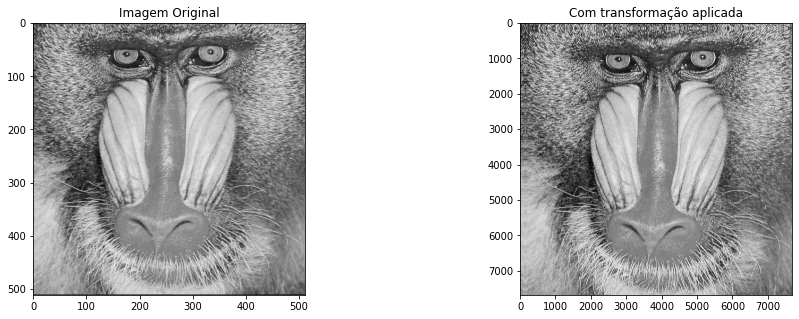

In [28]:
new_img = function(new_height, new_width, method_to_transform, interpolation_method, transformation, img)
plot_transform(img, new_img)

In [29]:
#Save the new image
io.imsave(opt.o, new_img)